In [1]:
import pickle as pkl
import torch
from torch import nn
from easy_tpp.preprocess.event_tokenizer import EventTokenizer
from easy_tpp.config_factory import DataSpecConfig
from models.encoders.gru import GRUTPPEncoder
from models.decoders.rmtpp import RMTPPDecoder, RMTPPLoss
from models import TPPModel

In [2]:
def preprocess_data(raw_data):
    # Validate input
    if not raw_data:
        raise ValueError("Input data is empty")
        
    # Create input data dictionary
    input_data = {
        'time_seqs': [[x["time_since_start"] for x in seq] for seq in raw_data],
        'type_seqs': [[x["type_event"] for x in seq] for seq in raw_data],
        'time_delta_seqs': [[x["time_since_last_event"] for x in seq] for seq in raw_data]
    }
    
    # # Print length of the sequences
    # for k, v in input_data.items():
    #     for seq in v:
    #         print(f"{k}: {len(seq)}")
    
    # Filter and validate sequences
    filtered_data = {
        k: [seq for seq in v if len(seq) > 0]
        for k, v in input_data.items()
    }
    
    # Check if we have any valid sequences after filtering
    if not filtered_data['type_seqs']:
        raise ValueError("No valid sequences found after filtering (all sequences were empty)")
        
    return filtered_data

def collate_fn(batch, config):
    tokenizer = EventTokenizer(config)
    tokenizer.padding_side = 'right'
    
    # get sequence length
    seq_lengths = [batch_item['sequence_length'] for batch_item in batch]
        
    # Pad sequences    
    padded_batch = tokenizer.pad(batch, 
                                 return_tensors='pt',
                                 return_attention_mask=None,
                                 padding='longest')
    
    # print(f"Final batch size: {len(padded_batch['type_seqs'])}")
    
    
    padded_batch['sequence_length'] = torch.tensor(seq_lengths)
    
    return padded_batch

In [3]:
dev_dict = pkl.load(open('data/earthquake/dev.pkl', 'rb'))
test_dict = pkl.load(open('data/earthquake/test.pkl', 'rb'))
train_dict = pkl.load(open('data/earthquake/train.pkl', 'rb'))

dim_process = train_dict['dim_process']
config = DataSpecConfig.parse_from_yaml_config({
    'num_event_types': dim_process,
    'pad_token_id': dim_process
})

In [ ]:
HIDDEN_DIM = 128
MLP_DIM = 64
device = 'cpu' if not torch.cuda.is_available() else 'cuda'
train_data = train_dict['train']
# processed_data = preprocess_data(train_data)
# processed_data = collate_fn(processed_data, config).to(device)
model = TPPModel(config, hidden_dim=HIDDEN_DIM, mlp_dim=MLP_DIM, device=device).to(device)

# print sizes of each time_seqs 
# print("Time Seqs Sizes:", processed_data['time_seqs'].size())
# decoder_output = model(processed_data)
# time_loss, mark_loss, total_loss = model.compute_loss(processed_data, decoder_output)

# print("Time Loss:", time_loss.item())
# print("Mark Loss:", mark_loss.item())
# print("Total Loss:", total_loss.item())

In [5]:
test_data = test_dict['test']
# processed_test_data = preprocess_data(test_data)
# processed_test_data = collate_fn(processed_test_data, config).to(device)
# model.eval()
# processed_test_data = {k: v.to(device) for k, v in processed_test_data.items()}

# with torch.no_grad():
#     test_decoder_output = model(processed_test_data)
#     test_time_loss, test_mark_loss, test_total_loss = model.compute_loss(processed_test_data, test_decoder_output)

# print("Test Time Loss:", test_time_loss.item())
# print("Test Mark Loss:", test_mark_loss.item())
# print("Test Total Loss:", test_total_loss.item())

In [6]:
from torch.utils.data import DataLoader, Dataset

# class EventDataset(Dataset):
#     def __init__(self, data):
#         self.data = data        

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         return self.data[idx]

class EventDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['type_seqs'])

    def __getitem__(self, idx):
        return {
            'time_seqs': self.data['time_seqs'][idx],
            'type_seqs': self.data['type_seqs'][idx],
            'time_delta_seqs': self.data['time_delta_seqs'][idx],
            'sequence_length': len(self.data['type_seqs'][idx])
        }
        

# Create datasets
preprocessed_train = preprocess_data(train_data)
preprocessed_test = preprocess_data(test_data)

train_dataset = EventDataset(preprocessed_train)
test_dataset = EventDataset(preprocessed_test)

# train_dataset = EventDataset(processed_data)
# test_dataset = EventDataset(processed_test_data)

# Create data loaders with collate function and arguments to prepare_data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda batch: collate_fn(batch, config), drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda batch: collate_fn(batch, config), drop_last=False)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Training loop
num_epochs = 200
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        decoder_output = model(batch)
        time_loss, mark_loss, total_loss = model.compute_loss(batch, decoder_output)
        total_loss.backward()
        optimizer.step()
        total_train_loss += total_loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

    # Evaluate on test data
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            decoder_output = model(batch)
            _, _, total_loss = model.compute_loss(batch, decoder_output)
            total_test_loss += total_loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Test Loss: {avg_test_loss:.4f}")

Epoch 1/200, Train Loss: 1.7911
Epoch 1/200, Test Loss: 0.2726
Epoch 2/200, Train Loss: 0.3403
Epoch 2/200, Test Loss: -0.3600
Epoch 3/200, Train Loss: -0.0578
Epoch 3/200, Test Loss: -0.6109
Epoch 4/200, Train Loss: -0.3210
Epoch 4/200, Test Loss: -0.8692
Epoch 5/200, Train Loss: -0.5515
Epoch 5/200, Test Loss: -1.0567
Epoch 6/200, Train Loss: -0.7721
Epoch 6/200, Test Loss: -1.3002
Epoch 7/200, Train Loss: -0.9409
Epoch 7/200, Test Loss: -1.4064
Epoch 8/200, Train Loss: -0.9888
Epoch 8/200, Test Loss: -1.4370
Epoch 9/200, Train Loss: -1.0277
Epoch 9/200, Test Loss: -1.4071
Epoch 10/200, Train Loss: -1.0584
Epoch 10/200, Test Loss: -1.5036
Epoch 11/200, Train Loss: -1.0863
Epoch 11/200, Test Loss: -1.5194
Epoch 12/200, Train Loss: -1.1140
Epoch 12/200, Test Loss: -1.5178
Epoch 13/200, Train Loss: -1.1322
Epoch 13/200, Test Loss: -1.5450
Epoch 14/200, Train Loss: -1.1480
Epoch 14/200, Test Loss: -1.5758
Epoch 15/200, Train Loss: -1.1699
Epoch 15/200, Test Loss: -1.5897
Epoch 16/200, Tr

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_event_sequence(time_seqs, type_seqs, time_delta_seqs, sequence_length, calculated_deltas, decoder_output, num_samples=5):
    for i in range(num_samples):
        time_seq = time_seqs[i].detach().cpu().numpy()
        type_seq = type_seqs[i].detach().cpu().numpy()
        time_delta_seq = time_delta_seqs[i].detach().cpu().numpy()
        seq_len = sequence_length[i].item()
        pred_time_delta_seq = calculated_deltas[i].detach().cpu().numpy() if calculated_deltas is torch.Tensor else calculated_deltas
        pred_mark_logits = decoder_output.mark_logits[i].detach().cpu().numpy()

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.plot(time_seq[:seq_len], type_seq[:seq_len], 'o-', label='True')
        plt.plot(time_seq[:seq_len], np.argmax(pred_mark_logits[:seq_len], axis=-1), 'o-', label='Predicted')
        plt.xlabel('Time')
        plt.ylabel('Event Type')
        plt.title('Event Sequence')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(time_seq[:seq_len], time_delta_seq[:seq_len], 'o-', label='True')
        plt.plot(time_seq[:seq_len], pred_time_delta_seq[:seq_len], 'o-', label='Calculated')
        plt.xlabel('Time')
        plt.ylabel('Time Delta')
        plt.title('Time Delta Sequence')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [ ]:
import numpy as np
from scipy import integrate
import torch
from torch.utils.data import DataLoader

def evaluate_tpp_model(model, test_dataloader, config, device):
    """
    Evaluate TPP model performance on test data.
    
    Args:
        model: TPP model instance
        test_dataloader: DataLoader for test data
        config: Configuration object containing model parameters
    
    Returns:
        dict: Dictionary containing evaluation metrics
    """
    model.eval()
    
    with torch.no_grad():
        event_total = 0
        all_cnt = np.zeros(config.num_event_types)
        acc_cnt = np.zeros(config.num_event_types)
        pre_cnt = np.zeros(config.num_event_types)
        time_error = 0
        predicted_intervals = []
        
        for batch in test_dataloader:
            # Move batch to device
            batch = {k: v.to(device) if torch.is_tensor(v) else v 
                    for k, v in batch.items()}
            
            # Get model predictions
            decoder_output = model(batch)
            
            # Get batch tensors
            time_seqs = batch['time_seqs'].cpu().numpy()  # absolute times
            time_delta_seqs = batch['time_delta_seqs'].cpu().numpy()  # time intervals
            sequence_length = batch['sequence_length']
            
            # Calculate event type accuracy
            event_total += sequence_length.sum().item()
            
            # Get predicted event types
            mark_logits = decoder_output.mark_logits
            event_output = torch.argmax(mark_logits, dim=-1).cpu().numpy()
            event_target = batch['type_seqs'].cpu().numpy()
            
            # Create mask for valid (non-padding) positions
            mask = torch.arange(event_target.shape[1])[None, :].to(device) < sequence_length[:, None].to(device)
            mask = mask.cpu().numpy()
            
            # Calculate event type statistics
            for i in range(event_target.shape[0]):  # For each sequence
                for j in range(event_target.shape[1]):  # For each position
                    if mask[i, j]:  # Only consider non-padding positions
                        all_cnt[event_target[i, j]] += 1
                        pre_cnt[event_output[i, j]] += 1
                        if event_output[i, j] == event_target[i, j]:
                            acc_cnt[event_output[i, j]] += 1
            
            # Calculate time prediction error
            time_output = decoder_output.time_output.squeeze(-1).cpu().numpy()  # [batch_size, seq_len]
            intensity_w = model.decoder.intensity_w.cpu().data.numpy()
            intensity_b = model.decoder.intensity_b.cpu().data.numpy()
            
            # Calculate expected time for each position in each sequence
            for i in range(time_output.shape[0]):  # For each sequence
                for j in range(time_output.shape[1]):  # For each position
                    if mask[i, j]:  # Only consider non-padding positions
                        # Get last time (time of previous event)
                        last_time = time_seqs[i, j-1] if j > 0 else 0.0
                        
                        # Get current history event value
                        history_event = time_output[i, j]
                        
                        # Integrate to get expected absolute time of next event
                        expected_next_time = integrate.quad(
                            lambda t: (t + last_time) * np.exp(
                                history_event + 
                                intensity_w * t + 
                                intensity_b + 
                                (np.exp(history_event + intensity_b) - 
                                 np.exp(history_event + intensity_w * t + intensity_b)) / intensity_w
                            ),
                            0, np.inf
                        )[0]
                        
                        # Calculate time delta error
                        # expected_next_time - last_time gives us the predicted interval
                        # time_delta_seqs[i, j] is the actual interval
                        predicted_interval = expected_next_time - last_time
                        actual_interval = time_delta_seqs[i, j]
                        time_error += np.abs(predicted_interval - actual_interval)
                        predicted_intervals.append(predicted_interval)
        
        # Calculate final metrics
        time_mae = time_error / event_total
        event_accuracy = acc_cnt.sum() / all_cnt.sum()
        
        # Calculate per-type metrics
        type_metrics = {}
        for event_type in range(config.num_event_types):
            if all_cnt[event_type] > 0:
                precision = acc_cnt[event_type] / pre_cnt[event_type] if pre_cnt[event_type] > 0 else 0
                recall = acc_cnt[event_type] / all_cnt[event_type]
                f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
                type_metrics[f'type_{event_type}'] = {
                    'precision': precision,
                    'recall': recall,
                    'f1': f1
                }
    
    return {
        'time_mae': time_mae,
        'event_accuracy': event_accuracy,
        'event_total': event_total,
        'type_metrics': type_metrics,
        'predicted_intervals': predicted_intervals
    }

In [ ]:
eval_metrics = evaluate_tpp_model(model, test_loader, config, device=device)

/tmp/ipykernel_1601498/1939964793.py:84: RuntimeWarning: overflow encountered in exp
  np.exp(history_event + intensity_w * t + intensity_b)) / intensity_w


In [10]:
eval_metrics.keys()

dict_keys(['time_mae', 'event_accuracy', 'event_total', 'type_metrics', 'predicted_intervals'])

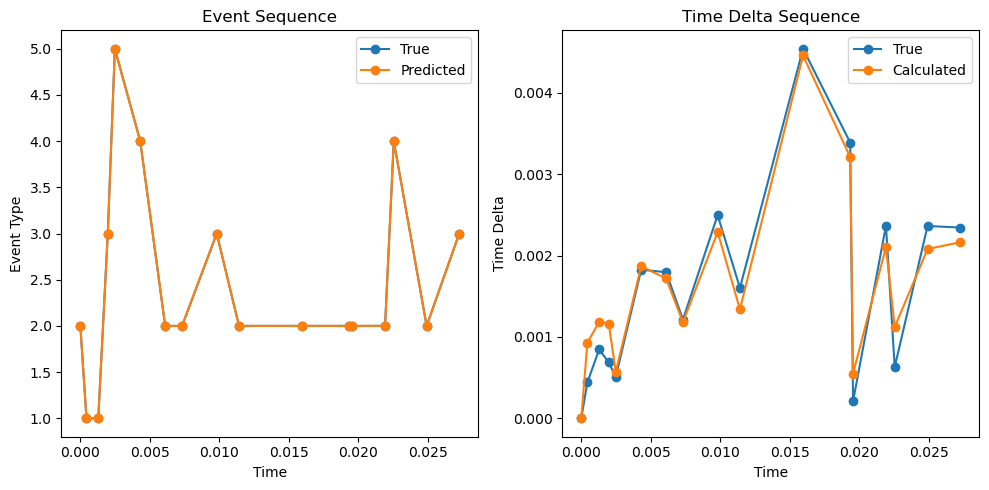

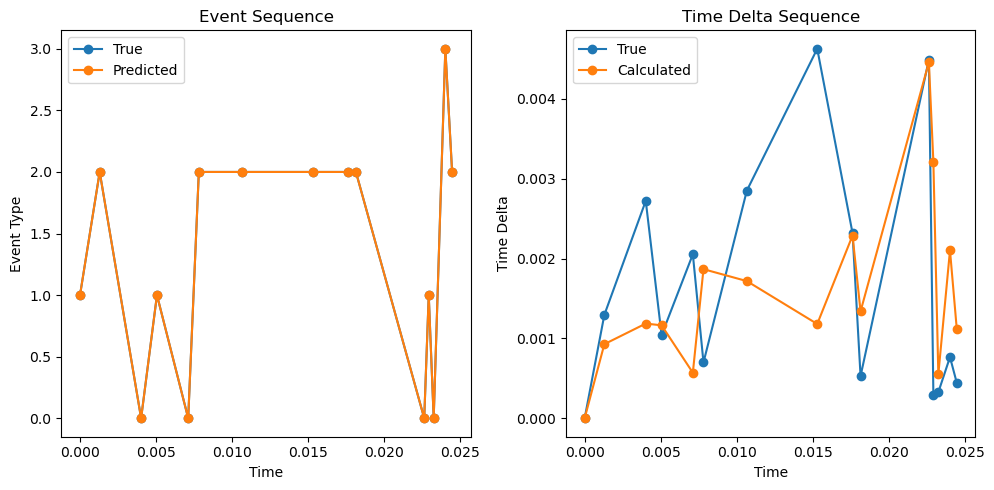

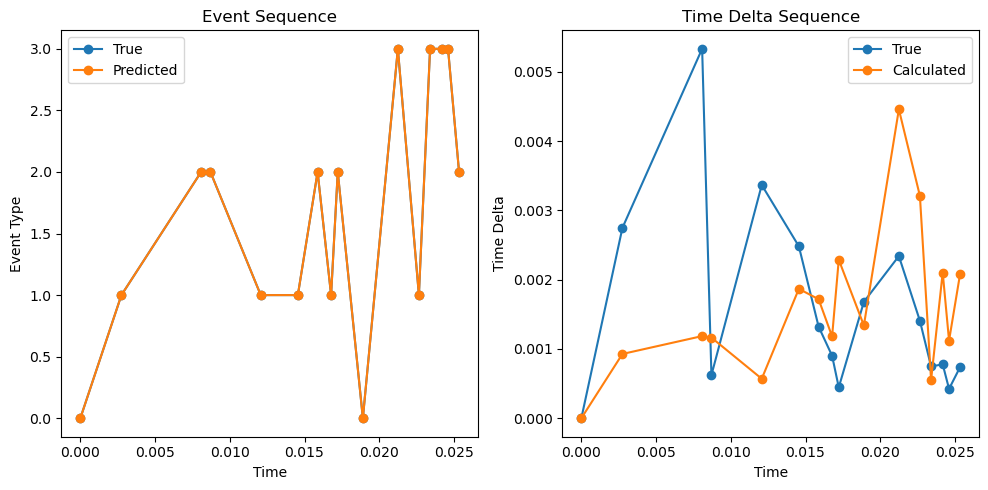

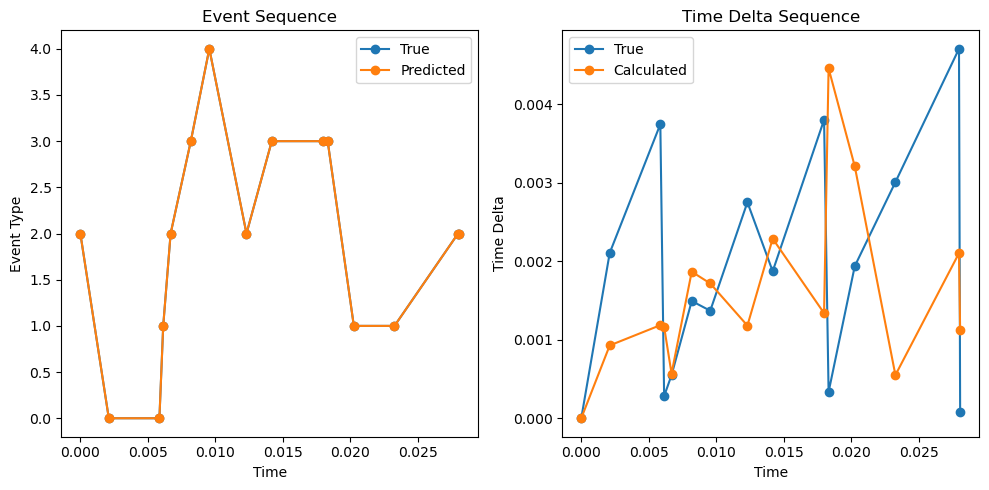

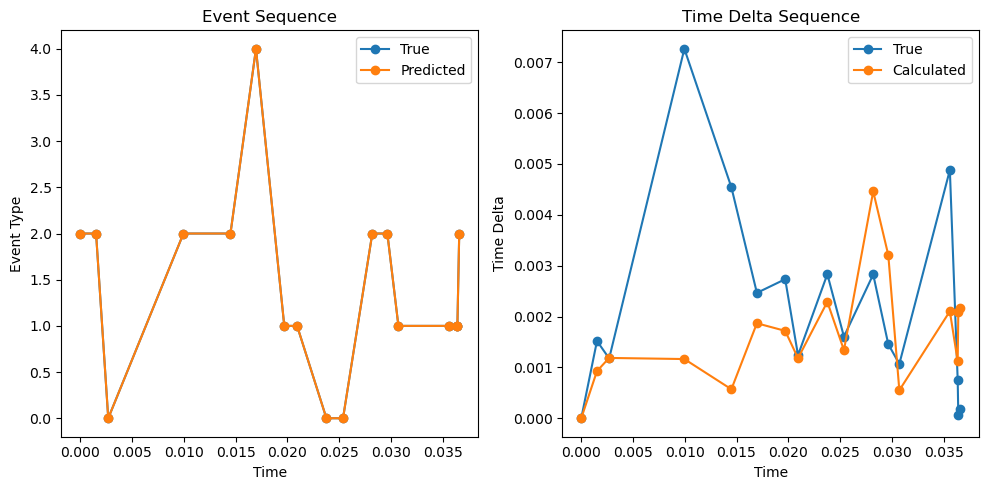

In [11]:
# plot the event sequences and the predicted event sequences
for batch in test_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    decoder_output = model(batch)
    plot_event_sequence(
        batch['time_seqs'], 
        batch['type_seqs'], 
        batch['time_delta_seqs'], 
        batch['sequence_length'], 
        eval_metrics['predicted_intervals'], 
        decoder_output
    )
    break
